In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import requests
from bs4 import BeautifulSoup

In [3]:
proxies = {'https': 'http://127.0.0.1:7769'} #I need this on my computer

In [4]:
#taken from https://senatestockwatcher.com/api
senate = pd.read_csv('datasets/all_transactions_senate.csv')

In [5]:
senate.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date
0,6/21/2022,Spouse,--,"Broadcom Corp <div class=""text-muted""><em>Rate...",Corporate Bond,Purchase,"$15,001 - $50,000",--,Thomas R Carper,https://efdsearch.senate.gov/search/view/ptr/a...,7/5/2022
1,6/15/2022,Spouse,--,"Office Properties Income Trust <div class=""tex...",Corporate Bond,Sale (Full),"$1,001 - $15,000",--,Thomas R Carper,https://efdsearch.senate.gov/search/view/ptr/a...,7/5/2022
2,5/17/2022,Spouse,--,Lee County Florida Health Care Facilities Reve...,Municipal Security,Purchase,"$500,001 - $1,000,000",--,Rick Scott,https://efdsearch.senate.gov/search/view/ptr/8...,6/16/2022
3,6/3/2022,Spouse,WFC,Wells Fargo &amp; Company Common Stock,Stock,Purchase,"$1,001 - $15,000",Dividend Reinvestment,"A. Mitchell Mcconnell, Jr.",https://efdsearch.senate.gov/search/view/ptr/5...,6/13/2022
4,5/31/2022,Joint,X,United States Steel Corporation Common Stock <...,Stock Option,Sale (Partial),"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022


Let's turn the dates into datetimes

In [6]:
senate['transaction_date'] = pd.to_datetime(senate['transaction_date'])
type(senate['transaction_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

Now let's create a year column

In [7]:
senate['year'] = senate['transaction_date'].map(lambda x: x.year)
senate.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,year
0,2022-06-21,Spouse,--,"Broadcom Corp <div class=""text-muted""><em>Rate...",Corporate Bond,Purchase,"$15,001 - $50,000",--,Thomas R Carper,https://efdsearch.senate.gov/search/view/ptr/a...,7/5/2022,2022
1,2022-06-15,Spouse,--,"Office Properties Income Trust <div class=""tex...",Corporate Bond,Sale (Full),"$1,001 - $15,000",--,Thomas R Carper,https://efdsearch.senate.gov/search/view/ptr/a...,7/5/2022,2022
2,2022-05-17,Spouse,--,Lee County Florida Health Care Facilities Reve...,Municipal Security,Purchase,"$500,001 - $1,000,000",--,Rick Scott,https://efdsearch.senate.gov/search/view/ptr/8...,6/16/2022,2022
3,2022-06-03,Spouse,WFC,Wells Fargo &amp; Company Common Stock,Stock,Purchase,"$1,001 - $15,000",Dividend Reinvestment,"A. Mitchell Mcconnell, Jr.",https://efdsearch.senate.gov/search/view/ptr/5...,6/13/2022,2022
4,2022-05-31,Joint,X,United States Steel Corporation Common Stock <...,Stock Option,Sale (Partial),"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022


In [8]:
senate['year'].value_counts()

2020    1535
2018    1395
2017    1372
2015    1152
2019    1037
2016     977
2014     727
2021     612
2022     347
2013     184
2012      60
Name: year, dtype: int64

In [9]:
senate.isnull().sum()

transaction_date       0
owner                465
ticker               465
asset_description      0
asset_type           666
type                 465
amount                 0
comment              465
senator                0
ptr_link               0
disclosure_date        0
year                   0
dtype: int64

We can see that there is a lot of null values

In [10]:
senate['amount'].value_counts()

$1,001 - $15,000             6084
$15,001 - $50,000            1664
$50,001 - $100,000            551
Unknown                       465
$100,001 - $250,000           335
$250,001 - $500,000           138
$500,001 - $1,000,000         111
$1,000,001 - $5,000,000        35
$5,000,001 - $25,000,000       12
$25,000,001 - $50,000,000       2
Over $50,000,000                1
Name: amount, dtype: int64

We see that one of the Senators invested over 50 million dollars in 1 trade! Let's see who it was

In [11]:
senate[senate['amount'] == "Over $50,000,000"]['senator']

7606    James M Inhofe
Name: senator, dtype: object

In [12]:
pd.options.display.max_rows = None


In [13]:
senate['ticker'].value_counts()

--                    1858
AAPL                   177
BAC                     86
MSFT                    85
NFLX                    79
PFE                     77
DIS                     75
DISCA                   74
T                       70
FEYE                    67
FDC                     66
URBN                    65
CZR                     63
FB                      58
AMZN                    55
NVDA                    54
WFC                     51
GE                      49
MRK                     46
PG                      45
WPX                     44
XOM                     44
DD                      44
WMT                     44
GM                      43
CVS                     43
HBI                     42
CSCO                    42
BA                      42
FDX                     41
INTC                    40
GPK                     40
MOS                     39
GLW                     39
CVX                     39
BWXT                    39
LYV                     38
Q

We see that 1858 entries have no ticker on them. Let's find out what percentage of the day that is. But first let's find out how many rows we have.

In [14]:
senate['ticker'].value_counts().sum()

8933

We have 8933 rows

In [15]:
(1858/8933) * 100

20.799283555356542

So almost 20.8% of the data has no ticker price. Sadily we will have to drop it, as we don't have anything to compare these trades to. Luckily we will still have over 6000 rows which is plenty to work with.

In [16]:
senate = senate[senate['ticker'] != '--']

In [17]:
senate.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,year
3,2022-06-03,Spouse,WFC,Wells Fargo &amp; Company Common Stock,Stock,Purchase,"$1,001 - $15,000",Dividend Reinvestment,"A. Mitchell Mcconnell, Jr.",https://efdsearch.senate.gov/search/view/ptr/5...,6/13/2022,2022
4,2022-05-31,Joint,X,United States Steel Corporation Common Stock <...,Stock Option,Sale (Partial),"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
5,2022-05-31,Joint,X,United States Steel Corporation Common Stock <...,Stock Option,Sale (Full),"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
6,2022-05-31,Joint,X,United States Steel Corporation Common Stock,Stock,Purchase,"$100,001 - $250,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
7,2022-05-20,Joint,PYPL,"PayPal Holdings, Inc. - Common Stock",Stock,Purchase,"$50,001 - $100,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022


In [18]:
senate['ticker'].value_counts()

AAPL                  177
BAC                    86
MSFT                   85
NFLX                   79
PFE                    77
DIS                    75
DISCA                  74
T                      70
FEYE                   67
FDC                    66
URBN                   65
CZR                    63
FB                     58
AMZN                   55
NVDA                   54
WFC                    51
GE                     49
MRK                    46
PG                     45
XOM                    44
WPX                    44
DD                     44
WMT                    44
GM                     43
CVS                    43
HBI                    42
BA                     42
CSCO                   42
FDX                    41
GPK                    40
INTC                   40
MOS                    39
GLW                    39
BWXT                   39
CVX                    39
SBUX                   38
QCOM                   38
GILD                   38
LYV         

Now let's check our Null values again

In [19]:
senate.isnull().sum()

transaction_date       0
owner                465
ticker               465
asset_description      0
asset_type           535
type                 465
amount                 0
comment              465
senator                0
ptr_link               0
disclosure_date        0
year                   0
dtype: int64

Let's drop any null rows

In [20]:
senate.dropna(inplace=True)

In [21]:
senate.isnull().sum()

transaction_date     0
owner                0
ticker               0
asset_description    0
asset_type           0
type                 0
amount               0
comment              0
senator              0
ptr_link             0
disclosure_date      0
year                 0
dtype: int64

Let's run head again and see what we need to edit.

In [22]:
senate.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,year
3,2022-06-03,Spouse,WFC,Wells Fargo &amp; Company Common Stock,Stock,Purchase,"$1,001 - $15,000",Dividend Reinvestment,"A. Mitchell Mcconnell, Jr.",https://efdsearch.senate.gov/search/view/ptr/5...,6/13/2022,2022
4,2022-05-31,Joint,X,United States Steel Corporation Common Stock <...,Stock Option,Sale (Partial),"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
5,2022-05-31,Joint,X,United States Steel Corporation Common Stock <...,Stock Option,Sale (Full),"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
6,2022-05-31,Joint,X,United States Steel Corporation Common Stock,Stock,Purchase,"$100,001 - $250,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
7,2022-05-20,Joint,PYPL,"PayPal Holdings, Inc. - Common Stock",Stock,Purchase,"$50,001 - $100,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022


In [23]:
senate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6540 entries, 3 to 8478
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   6540 non-null   datetime64[ns]
 1   owner              6540 non-null   object        
 2   ticker             6540 non-null   object        
 3   asset_description  6540 non-null   object        
 4   asset_type         6540 non-null   object        
 5   type               6540 non-null   object        
 6   amount             6540 non-null   object        
 7   comment            6540 non-null   object        
 8   senator            6540 non-null   object        
 9   ptr_link           6540 non-null   object        
 10  disclosure_date    6540 non-null   object        
 11  year               6540 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 664.2+ KB


We need to change amount and the discloser date. Let's round down for amount.

In [24]:
senate['amount'].value_counts()

$1,001 - $15,000             4655
$15,001 - $50,000            1157
$50,001 - $100,000            422
$100,001 - $250,000           237
$250,001 - $500,000            42
$500,001 - $1,000,000          11
$1,000,001 - $5,000,000        10
$5,000,001 - $25,000,000        5
$25,000,001 - $50,000,000       1
Name: amount, dtype: int64

In [25]:
list_of_amounts = []
nums_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
for i in senate['amount']:
    c = []
    for j in i:
        if j in nums_list:
            c.append(j)
        elif j == " ":
            break
    list_of_amounts.append(int("".join(c)))
list_of_amounts

[1001,
 15001,
 15001,
 100001,
 50001,
 250001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 100001,
 100001,
 250001,
 100001,
 1001,
 100001,
 1001,
 15001,
 50001,
 1001,
 50001,
 100001,
 15001,
 1001,
 1001,
 15001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 15001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 15001,
 1001,
 1001,
 15001,
 15001,
 50001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 15001,
 15001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 50001,
 50001,
 1001,
 1001,
 1001,
 1001,
 1001,
 1001,
 50001,
 1001,
 1001,
 1001,
 1001,
 1001,
 100001,
 1001,
 1001,
 1001,
 15001,
 1001,
 1001,
 1001,
 1001,
 50001,
 15001,
 1001,
 1

In [26]:
for i in range(len(list_of_amounts)):
    senate['amount'][i] = list_of_amounts[i]
senate['amount'].value_counts()

C:\Users\matth\AppData\Local\Temp/ipykernel_25436/447988909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senate['amount'][i] = list_of_amounts[i]


1001                         3712
$1,001 - $15,000              988
15001                         954
50001                         335
100001                        216
$15,001 - $50,000             186
$50,001 - $100,000             64
250001                         41
$100,001 - $250,000            16
500001                         10
1000001                         9
5000001                         4
$250,001 - $500,000             3
25000001                        1
$25,000,001 - $50,000,000       1
Name: amount, dtype: int64

For some reason that didn't change all the values. We will change the rest manually

In [27]:
senate['amount'] = senate['amount'].map(lambda x: 1001 if x == '$1,001 - $15,000' else x)

In [28]:
senate['amount'] = senate['amount'].map(lambda x: 15001 if x == '$15,001 - $50,000' else x)

In [29]:
senate['amount'] = senate['amount'].map(lambda x: 50001 if x == '$50,001 - $100,000' else x)

In [30]:
senate['amount'] = senate['amount'].map(lambda x: 100001 if x == '$100,001 - $250,000' else x)

In [31]:
senate['amount'] = senate['amount'].map(lambda x: 250001 if x == '$250,001 - $500,000' else x)

In [32]:
senate['amount'] = senate['amount'].map(lambda x: 2500001 if x == '$25,000,001 - $50,000,000' else x)

In [33]:
senate['amount'].value_counts()

1001        4700
15001       1140
50001        399
100001       232
250001        44
500001        10
1000001        9
5000001        4
25000001       1
2500001        1
Name: amount, dtype: int64

In [34]:
senate.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,year
3,2022-06-03,Spouse,WFC,Wells Fargo &amp; Company Common Stock,Stock,Purchase,100001,Dividend Reinvestment,"A. Mitchell Mcconnell, Jr.",https://efdsearch.senate.gov/search/view/ptr/5...,6/13/2022,2022
4,2022-05-31,Joint,X,United States Steel Corporation Common Stock <...,Stock Option,Sale (Partial),50001,--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
5,2022-05-31,Joint,X,United States Steel Corporation Common Stock <...,Stock Option,Sale (Full),250001,--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
6,2022-05-31,Joint,X,United States Steel Corporation Common Stock,Stock,Purchase,1001,--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022
7,2022-05-20,Joint,PYPL,"PayPal Holdings, Inc. - Common Stock",Stock,Purchase,1001,--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/4...,6/13/2022,2022


In [35]:
senate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6540 entries, 3 to 8478
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   6540 non-null   datetime64[ns]
 1   owner              6540 non-null   object        
 2   ticker             6540 non-null   object        
 3   asset_description  6540 non-null   object        
 4   asset_type         6540 non-null   object        
 5   type               6540 non-null   object        
 6   amount             6540 non-null   int64         
 7   comment            6540 non-null   object        
 8   senator            6540 non-null   object        
 9   ptr_link           6540 non-null   object        
 10  disclosure_date    6540 non-null   object        
 11  year               6540 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 922.3+ KB


Now it is time for disclosure_date

In [36]:
senate['disclosure_date'] = pd.to_datetime(senate['disclosure_date'])
senate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6540 entries, 3 to 8478
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   6540 non-null   datetime64[ns]
 1   owner              6540 non-null   object        
 2   ticker             6540 non-null   object        
 3   asset_description  6540 non-null   object        
 4   asset_type         6540 non-null   object        
 5   type               6540 non-null   object        
 6   amount             6540 non-null   int64         
 7   comment            6540 non-null   object        
 8   senator            6540 non-null   object        
 9   ptr_link           6540 non-null   object        
 10  disclosure_date    6540 non-null   datetime64[ns]
 11  year               6540 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 922.3+ KB


The data looks clean now! Let's see if we can do some EDA

In [37]:
senate['owner'].value_counts()

Joint     3259
Spouse    2205
Self       956
Child      120
Name: owner, dtype: int64

<AxesSubplot:xlabel='owner', ylabel='amount'>

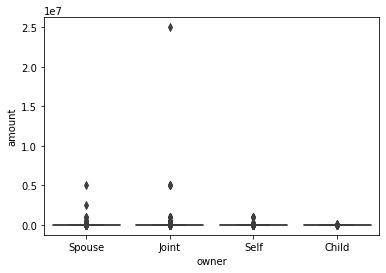

In [38]:
sns.boxplot(data=senate, x=senate['owner'], y=senate['amount'])

We cant see much because of the huge outlier. Let's temporaly remove it

In [39]:
s_box = senate[senate['amount'] < 25000000]

In [41]:
s_box['amount'].value_counts()

1001       4700
15001      1140
50001       399
100001      232
250001       44
500001       10
1000001       9
5000001       4
2500001       1
Name: amount, dtype: int64

<AxesSubplot:xlabel='owner', ylabel='amount'>

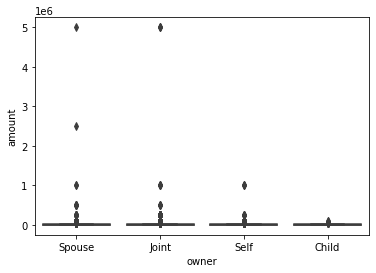

In [42]:
sns.boxplot(data=s_box, x=s_box['owner'], y=s_box['amount'])

In [43]:
senate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6540 entries, 3 to 8478
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   6540 non-null   datetime64[ns]
 1   owner              6540 non-null   object        
 2   ticker             6540 non-null   object        
 3   asset_description  6540 non-null   object        
 4   asset_type         6540 non-null   object        
 5   type               6540 non-null   object        
 6   amount             6540 non-null   int64         
 7   comment            6540 non-null   object        
 8   senator            6540 non-null   object        
 9   ptr_link           6540 non-null   object        
 10  disclosure_date    6540 non-null   datetime64[ns]
 11  year               6540 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 922.3+ KB


In [45]:
senate['asset_type'].value_counts()

Stock               6054
Stock Option         251
Other Securities     223
Corporate Bond         9
Cryptocurrency         3
Name: asset_type, dtype: int64

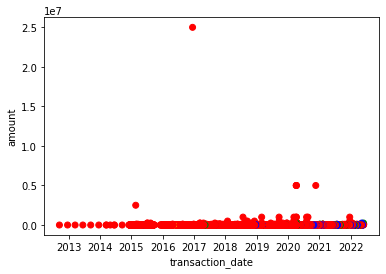

In [50]:
#taken from lesson 4.01
# matplotlib KNN visualization
import matplotlib.pyplot as plt
colors = {'Stock': 'red', 'Stock Option':'green', 'Other Securities':'blue', 'Corporate Bond':'yellow', 'Cryptocurrency':'purple'}

color_series = senate['asset_type'].map(colors)

plt.scatter(senate['transaction_date'],
           senate['amount'],
           color = color_series)

plt.xlabel('transaction_date')
plt.ylabel('amount');

Again the one really big trade makes it harder to see the other trades

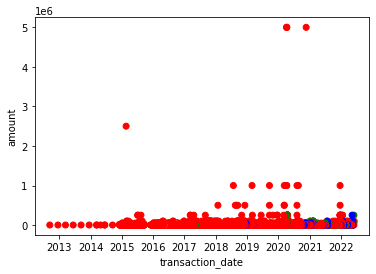

In [51]:
color_series = s_box['asset_type'].map(colors)

plt.scatter(s_box['transaction_date'],
           s_box['amount'],
           color = color_series)

plt.xlabel('transaction_date')
plt.ylabel('amount');

Finally, we will export the cleaned csv file.

In [53]:
senate.to_csv('datasets/cleaned_senate.csv')